# MMI prediction

## 4. Feature engineering
- Change levels of certain features
- Drop some features manually
- Drop more features with variance thresholding
- Drop more features with RFE
- Format labels
- Preprocess testing set and save

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pickle import dump, load

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.utils import resample

In [28]:
pd.set_option('display.max_columns', 500)

In [29]:
# load data

X_train = pd.read_pickle('X_train.pkl')
y_train = pd.read_pickle('y_train.pkl')
print('There are {} training samples'.format(X_train.shape[0]))

There are 304 training samples


## Scale, impute, and select features

In [30]:
# change levels of certain factors

X_train['tici_success'] = np.where(X_train['tici'].str.contains('3|2B', regex = True), 'Y', 'N')
X_train['coll_full'] = np.where(X_train['coll_score'] == 3.0, 'Y', 'N')
X_train['pre_mrs_0'] = np.where(X_train['pre_mrs'] == 0.0, 'Y', 'N')

In [31]:
# remove variables that have too many missing values/don't provide much information or have been transformed

vars_to_drop = ['race', 'mag', 'phos', 'gen_anes_vol', 'tici', 'coll_score', 'pre_mrs']
X_train = X_train.drop(vars_to_drop, axis = 1)

In [32]:
# identify categorical and continuous vars

cont_columns_selector = selector(dtype_exclude = object)
cat_columns_selector = selector(dtype_include = object)

cont_columns = cont_columns_selector(X_train)
cat_columns = cat_columns_selector(X_train)
all_columns = list(X_train.columns)

In [33]:
print(cat_columns)

['hypox', 'wake_up', 'seizure', 'transfer', 'tpa', 'stroke_etiol', 'sex', 'htn', 'dm', 'ckd', 'hld', 'afib', 'smoking', 'prior_stroke', 'ac_ap', 'left', 'occ_site', 'tandem', 'hyperdense', 'approach', 'ptas', 'stent_ret', 'aspiration', 'bgc', 'first_pass_reperf', 'rescue_ia', 'procedure_ap', 'gen_anes', 'hypoten_mt', 'trevo', 'solitaire', 'embotrap', 'capture', 'tici_success', 'coll_full', 'pre_mrs_0']


In [34]:
X_train[cont_columns].shape

(304, 26)

In [35]:
# test different variance thresholds

thresholds = np.arange(0, 0.55, 0.05)

for t in thresholds:
    selector = VarianceThreshold(threshold = t)    
    X_sel = selector.fit_transform(X_train[cont_columns])
    print('at threshold {} there are {} features'.format(t, X_sel.shape[1]))

at threshold 0.0 there are 26 features
at threshold 0.05 there are 25 features
at threshold 0.1 there are 24 features
at threshold 0.15000000000000002 there are 22 features
at threshold 0.2 there are 22 features
at threshold 0.25 there are 22 features
at threshold 0.30000000000000004 there are 22 features
at threshold 0.35000000000000003 there are 22 features
at threshold 0.4 there are 21 features
at threshold 0.45 there are 21 features
at threshold 0.5 there are 21 features


In [36]:
# instantiate the pre-processing pipelines for categorical and continuous variables

cat_preprocessor = Pipeline(steps = [
    ('ordinal encoder', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('one hot encoder', OneHotEncoder(handle_unknown = 'ignore'))])
cont_preprocessor = Pipeline(steps = [
    ('variance_selector', VarianceThreshold(threshold = 0.5)),
    ('imputer', IterativeImputer(max_iter = 100, random_state = 0)),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers = [
        ('cont', cont_preprocessor, cont_columns), 
        ('cat', cat_preprocessor, cat_columns)])

In [37]:
# apply preprocessing

X_train_trans = pd.DataFrame(preprocessor.fit_transform(X_train))

# save preprocessor for use on test set later

dump(preprocessor, open('preprocessor.pkl', 'wb'))

In [38]:
# get column names for transformed dataframe

cont_col_names = preprocessor.transformers_[0][1].named_steps['variance_selector'].get_feature_names_out(cont_columns).tolist()
cat_col_names = preprocessor.transformers_[1][1].named_steps['one hot encoder'].get_feature_names(cat_columns).tolist()

X_train_trans.columns = cont_col_names + cat_col_names

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
X_train_trans.head()

,glucose,a1c,plt,plt_lymph,sbp,map,nih_admit,age,bmi,cbf_30,tmax_6,tmax_10,mismatch_vol,aspects,heparin,stent_ret_length,num_pass,fluoro_time,time_to_arr,time_to_puncture,time_to_reperf,hypox_0.0,hypox_1.0,wake_up_0.0,wake_up_1.0,seizure_0.0,seizure_1.0,transfer_0.0,transfer_1.0,tpa_0.0,tpa_1.0,stroke_etiol_0.0,stroke_etiol_1.0,stroke_etiol_2.0,stroke_etiol_3.0,sex_0.0,sex_1.0,htn_0.0,htn_1.0,dm_0.0,dm_1.0,ckd_0.0,ckd_1.0,hld_0.0,hld_1.0,afib_0.0,afib_1.0,smoking_0.0,smoking_1.0,prior_stroke_0.0,prior_stroke_1.0,ac_ap_0.0,ac_ap_1.0,left_0.0,left_1.0,occ_site_0.0,occ_site_1.0,occ_site_2.0,tandem_0.0,tandem_1.0,hyperdense_0.0,hyperdense_1.0,approach_0.0,approach_1.0,ptas_0.0,ptas_1.0,stent_ret_0.0,stent_ret_1.0,aspiration_0.0,aspiration_1.0,bgc_0.0,bgc_1.0,first_pass_reperf_0.0,first_pass_reperf_1.0,rescue_ia_0.0,rescue_ia_1.0,procedure_ap_0.0,procedure_ap_1.0,gen_anes_0.0,gen_anes_1.0,hypoten_mt_0.0,hypoten_mt_1.0,trevo_0.0,trevo_1.0,solitaire_0.0,solitaire_1.0,embotrap_0.0,embotrap_1.0,capture_0.0,capture_1.0,tici_success_0.0,tici_success_1.0,coll_full_0.0,coll_full_1.0,pre_mrs_0_0.0,pre_mrs_0_1.0
0,-0.921955,-0.759994,-0.798497,-0.625854,0.091301,1.044710,0.553903,-1.493186,0.540134,0.966942,0.400804,0.907203,-0.032632,0.919622,-0.743269,-1.090077,-0.012076,-0.164048,-0.589288,-0.261114,-0.607997,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,-0.246443,-0.841672,-0.245795,0.044429,-0.959754,-0.781187,1.220120,0.623648,-0.738345,-0.539575,0.068010,-0.301640,0.343590,-2.805945,1.139679,2.028570,-0.822888,-0.367396,-0.241039,-0.252688,-0.368309,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,-0.748083,-0.024892,-0.883161,-0.564881,-0.025482,0.759414,-1.611304,-1.427035,-0.596291,0.955967,0.233096,0.764192,-0.063931,-0.943161,-0.743269,-1.090077,1.609548,0.110129,-0.311750,-0.136411,-0.283441,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.077808,-0.596638,-0.502172,-0.636016,0.558437,-0.552949,1.053566,1.483612,-0.880398,-1.010454,-0.039119,-0.459649,0.506488,-0.011769,0.512030,0.226731,-0.012076,-0.159478,-0.529184,-0.272911,-0.588431,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,-0.487275,-0.351604,-0.163514,0.263338,-0.609402,-0.096475,1.053566,-1.890093,-1.022451,0.516773,-0.059131,0.179140,-0.368878,-0.011769,1.139679,2.028570,-0.822888,-0.177757,0.731228,-0.138096,0.435134,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [40]:
# check feature importances

rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(X_train_trans, y_train)

names = []
scores = []

for name, score in zip(X_train_trans.columns, rnd_clf.feature_importances_):
    names.append(name)
    scores.append(score)
feat_imp = pd.DataFrame({'var': names, 'scores': scores})
print(feat_imp.sort_values('scores', ascending = False))
feat_imp.to_pickle('feat_imp.pkl')

<ipython-input-40-8e4040eec4c2>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rnd_clf.fit(X_train_trans, y_train)


               var    scores
16        num_pass  0.066376
4              sbp  0.045148
1              a1c  0.036762
2              plt  0.036320
0          glucose  0.034780
..             ...       ...
42         ckd_1.0  0.001060
81  hypoten_mt_1.0  0.000812
88     capture_0.0  0.000723
89     capture_1.0  0.000686
41         ckd_0.0  0.000510

[96 rows x 2 columns]


/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:310: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X[:, features], y, **fit_params)
/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:283: 

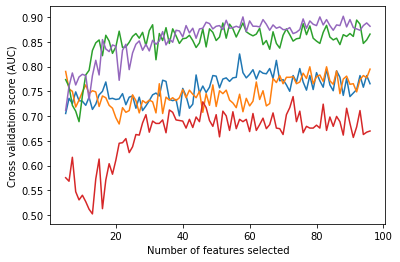

In [41]:
# instantiate/fit recursive feature elimination

min_features_to_select = 5

rfe = RFECV(RandomForestClassifier(n_estimators = 500), cv = 5, scoring = 'roc_auc', 
           min_features_to_select = min_features_to_select)
rfe.fit(X_train_trans, y_train)

# plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (AUC)')
plt.plot(
    range(min_features_to_select, len(rfe.grid_scores_) + min_features_to_select),
    rfe.grid_scores_,
)
plt.show()

In [42]:
print('Optimal number of features : {}'.format(rfe.n_features_))

Optimal number of features : 83


In [43]:
len(rfe.get_feature_names_out(X_train_trans.columns))

83

In [44]:
# apply recursive feature elimination

X_train_trans = pd.DataFrame(rfe.transform(X_train_trans))
X_train_trans.columns = rfe.get_feature_names_out(cont_col_names + cat_col_names).tolist()

In [45]:
# save recursive feature elimination model for later use on test set

dump(rfe, open('rfe.pkl', 'wb'))

## Format labels

In [46]:
y_train.value_counts()

0    265
1     39
dtype: int64

In [47]:
# convert target to numerical

le = LabelEncoder()
y_train = le.fit_transform(y_train)

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
X_train_trans.to_pickle('X_train_trans.pkl')
pd.DataFrame(y_train).to_pickle('y_train.pkl')

## Function for preprocessing test data

In [56]:
def preprocess(X_test, preprocessor_path, rfe_path):
    
    # change levels of certain factors
    X_test['tici_success'] = np.where(X_test['tici'].str.contains('3|2B', regex = True), 'Y', 'N')
    X_test['coll_full'] = np.where(X_test['coll_score'] == 3.0, 'Y', 'N')
    X_test['pre_mrs_0'] = np.where(X_test['pre_mrs'] == 0.0, 'Y', 'N')
    
    # remove variables that have too many missing values/don't provide much information or have been transformed
    vars_to_drop = ['race', 'mag', 'phos', 'gen_anes_vol', 'tici', 'coll_score', 'pre_mrs']
    X_test = X_test.drop(vars_to_drop, axis = 1)
    
    # identify categorical and continuous vars
    cont_columns_selector = selector(dtype_exclude = object)
    cat_columns_selector = selector(dtype_include = object)

    cont_columns = cont_columns_selector(X_test)
    cat_columns = cat_columns_selector(X_test)
    all_columns = list(X_test.columns)
    
    # load and apply preprocessor
    preprocessor = load(open(preprocessor_path, 'rb'))
    X_test = pd.DataFrame(preprocessor.transform(X_test))
    
    # get column names for transformed dataframe
    cont_col_names = preprocessor.transformers_[0][1].named_steps['variance_selector'].get_feature_names_out(cont_columns).tolist()
    cat_col_names = preprocessor.transformers_[1][1].named_steps['one hot encoder'].get_feature_names(cat_columns).tolist()
    X_test.columns = cont_col_names + cat_col_names
    
    # apply rfe and adjust column names
    rfe = load(open(rfe_path, 'rb'))
    X_test = pd.DataFrame(rfe.transform(X_test))
    X_test.columns = rfe.get_feature_names_out(cont_col_names + cat_col_names).tolist()
    
    return X_test

In [57]:
X_test = pd.read_pickle('X_test.pkl')
X_test = preprocess(X_test = X_test, preprocessor_path = 'preprocessor.pkl', rfe_path = 'rfe.pkl')
X_test.to_pickle('X_test_processed.pkl')

/Users/haydnhoffman/ml/my_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
